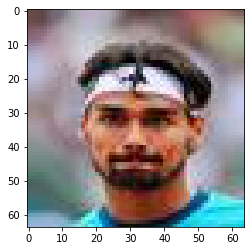

In [1]:
#Create a folder called celeba in home dir where reconstructed images will be stored
#Considered only 100000 images for training

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as utils
import gc
import pywt
import IPython
import random
from random import sample
with __import__('importnb').Notebook():
        from PyTorch_notsobiggan_test64 import CelebaDataset, VAE, Flatten

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
CUDA = True
BATCH_SIZE = 32
LOG_INTERVAL = 5
h_img = 64
w_img = 64
flat = h_img*w_img*3
train_losses = []

In [2]:
w=pywt.Wavelet('bior2.2')


dec_hi = torch.Tensor(w.dec_hi[::-1]).cuda() 
dec_lo = torch.Tensor(w.dec_lo[::-1]).cuda()
rec_hi = torch.Tensor(w.rec_hi).cuda()
rec_lo = torch.Tensor(w.rec_lo).cuda()

inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)

def iwt(vres, levels=1):
    h = vres.size(2)
    w = vres.size(3)
    res = vres.contiguous().view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
    print(res.shape)
    if levels>1:
        res[:,:1] = iwt(res[:,:1], levels=levels-1)
    res = torch.nn.functional.conv_transpose2d(res, Variable(inv_filters[:,None]),stride=2)
    res = res[:,:,2:-2,2:-2] #removing padding
#     print(res.shape)
    return res

def truncated_normal_(tensor, mean=0, std=0.02):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)
    
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        with torch.no_grad():
            truncated_normal_(m.weight.data, mean=0, std=0.02)
        nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean=0, std=0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [3]:
class LearnIWT(nn.Module):
    def __init__(self, image_channels=3, z_dim=100, device=None):
        super(LearnIWT, self).__init__()
        
        if device is None:
            self.cuda = False
            self.device = None
        else:
            self.device = device
            self.cuda = True
        
        self.z_dim = z_dim
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # X - Y Residual Encoder
        self.e1 = nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 64, 32, 32]
        weights_init(self.e1)
        self.instance_norm_e1 = nn.InstanceNorm2d(num_features=64, affine=False)

        self.e2 = nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 128, 16, 16]
        weights_init(self.e2)
        self.instance_norm_e2 = nn.InstanceNorm2d(num_features=128, affine=False)

        self.e3 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 256, 8, 8]
        weights_init(self.e3)
        self.instance_norm_e3 = nn.InstanceNorm2d(num_features=256, affine=False)

        self.e4 = nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 512, 4, 4]
        weights_init(self.e4)
        self.instance_norm_e4 = nn.InstanceNorm2d(num_features=512, affine=False)
        
        self.fc_enc = nn.Linear(512 * 4 * 4, 256)
        weights_init(self.fc_enc)
        
        self.fc_mean = nn.Linear(256, z_dim)
        weights_init(self.fc_mean)
        
        self.fc_var = nn.Linear(256, z_dim)
        weights_init(self.fc_var)
        
        # IWT Decoder        
        self.d1 = nn.Linear(3 * 64 * 64, 3 * 64 * 64)
        weights_init(self.d1)
        self.mu1 = nn.Linear(z_dim, 3 * 64 * 64)
        self.var1 = nn.Linear(z_dim, 3 * 64 * 64)
        self.instance_norm_d1 = nn.InstanceNorm2d(num_features=3, affine=False)
        self.iwt1 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2)
        
        self.d2 = nn.Linear(3 * 64 * 64, 3 * 64 * 64)
        weights_init(self.d2)
        self.mu2 = nn.Linear(z_dim, 3 * 64 * 64)
        self.var2 = nn.Linear(z_dim, 3 * 64 * 64)
        self.instance_norm_d2 = nn.InstanceNorm2d(num_features=3, affine=False)
        self.iwt2 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2)
        
    
    def encode(self, x, y):
        h = self.leakyrelu(self.instance_norm_e1(self.e1(x-y)))   #[b, 64, 32, 32]
        h = self.leakyrelu(self.instance_norm_e2(self.e2(h)))     #[b, 128, 16, 16]
        h = self.leakyrelu(self.instance_norm_e3(self.e3(h)))     #[b, 256, 8, 8]
        h = self.leakyrelu(self.instance_norm_e4(self.e4(h)))     #[b, 512, 4, 4]
        h = self.leakyrelu(self.fc_enc(h.view(-1,512*4*4)))       #[b, 512 * 4 * 4]
        
        return self.fc_mean(h), F.softplus(self.fc_var(h))        #[b, z_dim]

    def reparameterize(self, mu, var):
        std = torch.sqrt(var)
        if self.cuda:
            eps = torch.FloatTensor(std.size()).normal_().to(self.device)
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu) 
    
    def decode(self, y, z):
        mu = self.mu1(z).reshape(-1, 3, 64, 64)
        var = self.var1(z).reshape(-1, 3, 64, 64)
        h = self.leakyrelu(var*self.instance_norm_d1(self.d1(y.view(y.shape[0], -1)).reshape(-1, 3, 64, 64)) + mu) #[b, 3, 64, 64]
        h = self.leakyrelu(self.iwt1(h))                               #[b, 3, 64, 64]
        
        mu = self.mu2(z).reshape(-1, 3, 64, 64)
        var = self.var2(z).reshape(-1, 3, 64, 64)
        h = self.leakyrelu(var*self.instance_norm_d2(self.d1(h.view(h.shape[0], -1)).reshape(-1, 3, 64, 64)) + mu) #[b, 3, 64, 64]
        h = self.leakyrelu(self.iwt2(h))                               #[b, 3, 64, 64]
        
        return self.sigmoid(h)
        
        
    def forward(self, x, y):
        mu, var = self.encode(x, y)
        if self.training:
            z = self.reparameterize(mu, var)
        else:
            z = mu
        x_hat = self.decode(y, z)
        
        return x_hat, mu, var
        
        
    def loss_function(self, x, x_hat, mu, var) -> Variable:
        
        # Loss btw reconstructed img and original img
        BCE = F.mse_loss(x_hat.view(-1), x.view(-1))
        
        logvar = torch.log(var)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.01

        return BCE + KLD
        
        
        

In [4]:
# test = torch.zeros((32,3,32,32))
# test1 = test.contiguous().view(-1,32//2,2,32//2).transpose(1,2).contiguous().view(-1,4,32//2,32//2).clone()
# print(test1.shape)
# #torch.nn.functional.conv_transpose2d(test1.cuda(), Variable(inv_filters[:,None]),stride=2)
# t = nn.ConvTranspose2d(3, 3, kernel_size=6, stride=2)
# t1 = Variable(inv_filters[:,None])
# print(t1.shape)
# print(t.weight.shape)

# with torch.no_grad():
#     t.weight = torch.nn.Parameter(t1)

In [5]:
# Create celeba dataset
root_dir = "celeba64/"
image_files = os.listdir(root_dir)
train_dataset = CelebaDataset('celeba64/', image_files, WT=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=10, shuffle=True)
sample_dataset = Subset(train_dataset, sample(range(len(train_dataset)), 8))
sample_loader = DataLoader(sample_dataset, batch_size=8, shuffle=False)

In [6]:
# Zeroing out all other patches than the first for WT image: 4D: B * C * H * W
def zero_patches(img):
    zeros = torch.zeros((img.shape[0], img.shape[1], img.shape[2], img.shape[3]))
    zeros[:,:,:16,:16] = img[:,:,:16,:16]
    
    return zeros

In [7]:
def train(epoch, model, optimizer, train_loader):
    # toggle model to train mode
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        
        if CUDA:
            data0 = data.to('cuda:0')
            data1 = data.clone().to('cuda:1')

        optimizer.zero_grad()
        
        # Get Y
        Y = wt_model(data1)[0]
        # Zeroing out all other patches
        Y = zero_patches(Y)
        x_hat, mu, var = iwt_model(data0, Y.to('cuda:0'))
        # Fix loss function
        loss = iwt_model.loss_function(x_hat, data0, mu, var)
        loss.backward()
        
        train_losses.append(loss.item())
        train_loss += loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss / len(data)))
            
            n = min(data.size(0), 8)  

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
# Loading WT model and setting to eval for inference
wt_model = VAE()
wt_model.load_state_dict(torch.load('./wtvae_2wt_models/wtvae_epoch88.pth'))
wt_model.to('cuda:1')
wt_model.eval()
iwt_model = LearnIWT(device='cuda:0').to('cuda:0')

train_losses = []
gc.collect()
EPOCHS = 100

optimizer = optim.Adam(iwt_model.parameters(), lr=1e-3)

for epoch in range(1, EPOCHS + 1):
    train(epoch, iwt_model, optimizer, train_loader)

    with torch.no_grad():
        iwt_model.eval()

        for data in sample_loader:
            if CUDA:
                data0 = data.to('cuda:0')
                data1 = data.to('cuda:1')
            
            z_sample = torch.randn(data.shape[0],100).to('cuda:0')
            
            Y = wt_model(data1)[0].to('cuda:0')
            mu, var = iwt_model.encode(data0, Y)
            x_hat = iwt_model.decode(Y, mu)
            x_sample = iwt_model.decode(Y, z_sample)
            
            save_image(x_hat.cpu(), './image_samples/celeba_dsvae_1/sample_recon' + str(epoch) + '.png') 
            save_image(x_sample.cpu(), './image_samples/celeba_dsvae_1/sample_z' + str(epoch) + '.png')
            save_image(Y.cpu(), './image_samples/celeba_dsvae_1/sample_y' + str(epoch) + '.png') 
            save_image(data.cpu(), './image_samples/celeba_dsvae_1/sample' + str(epoch) + '.png')  
    
    torch.save(iwt_model.state_dict(), './models/iwtvae64_models_rest0/iwtvae_epoch{}.pth'.format(epoch))

Train Epoch: 1 [0/10000 (0%)]	Loss: 0.085773
Train Epoch: 1 [160/10000 (2%)]	Loss: 0.025499
Train Epoch: 1 [320/10000 (3%)]	Loss: 0.009889
Train Epoch: 1 [480/10000 (5%)]	Loss: 0.006671
Train Epoch: 1 [640/10000 (6%)]	Loss: 0.004920
Train Epoch: 1 [800/10000 (8%)]	Loss: 0.003916
Train Epoch: 1 [960/10000 (10%)]	Loss: 0.003503
Train Epoch: 1 [1120/10000 (11%)]	Loss: 0.003079
Train Epoch: 1 [1280/10000 (13%)]	Loss: 0.002802
Train Epoch: 1 [1440/10000 (14%)]	Loss: 0.002888
Train Epoch: 1 [1600/10000 (16%)]	Loss: 0.002787
Train Epoch: 1 [1760/10000 (18%)]	Loss: 0.002635
Train Epoch: 1 [1920/10000 (19%)]	Loss: 0.002524
Train Epoch: 1 [2080/10000 (21%)]	Loss: 0.002692
Train Epoch: 1 [2240/10000 (22%)]	Loss: 0.002817
Train Epoch: 1 [2400/10000 (24%)]	Loss: 0.002504
Train Epoch: 1 [2560/10000 (26%)]	Loss: 0.002422
Train Epoch: 1 [2720/10000 (27%)]	Loss: 0.002507
Train Epoch: 1 [2880/10000 (29%)]	Loss: 0.002432
Train Epoch: 1 [3040/10000 (30%)]	Loss: 0.002254
Train Epoch: 1 [3200/10000 (32%)]	L

Train Epoch: 3 [6560/10000 (65%)]	Loss: 0.001359
Train Epoch: 3 [6720/10000 (67%)]	Loss: 0.001275
Train Epoch: 3 [6880/10000 (69%)]	Loss: 0.001192
Train Epoch: 3 [7040/10000 (70%)]	Loss: 0.001250
Train Epoch: 3 [7200/10000 (72%)]	Loss: 0.001246
Train Epoch: 3 [7360/10000 (73%)]	Loss: 0.001235
Train Epoch: 3 [7520/10000 (75%)]	Loss: 0.001062
Train Epoch: 3 [7680/10000 (77%)]	Loss: 0.001226
Train Epoch: 3 [7840/10000 (78%)]	Loss: 0.001219
Train Epoch: 3 [8000/10000 (80%)]	Loss: 0.001228
Train Epoch: 3 [8160/10000 (81%)]	Loss: 0.001153
Train Epoch: 3 [8320/10000 (83%)]	Loss: 0.001174
Train Epoch: 3 [8480/10000 (85%)]	Loss: 0.001167
Train Epoch: 3 [8640/10000 (86%)]	Loss: 0.001180
Train Epoch: 3 [8800/10000 (88%)]	Loss: 0.001087
Train Epoch: 3 [8960/10000 (89%)]	Loss: 0.001304
Train Epoch: 3 [9120/10000 (91%)]	Loss: 0.001151
Train Epoch: 3 [9280/10000 (93%)]	Loss: 0.001159
Train Epoch: 3 [9440/10000 (94%)]	Loss: 0.001006
Train Epoch: 3 [9600/10000 (96%)]	Loss: 0.001174
Train Epoch: 3 [9760

Train Epoch: 6 [2880/10000 (29%)]	Loss: 0.000951
Train Epoch: 6 [3040/10000 (30%)]	Loss: 0.000911
Train Epoch: 6 [3200/10000 (32%)]	Loss: 0.000931
Train Epoch: 6 [3360/10000 (34%)]	Loss: 0.000925
Train Epoch: 6 [3520/10000 (35%)]	Loss: 0.001078
Train Epoch: 6 [3680/10000 (37%)]	Loss: 0.000895
Train Epoch: 6 [3840/10000 (38%)]	Loss: 0.001051
Train Epoch: 6 [4000/10000 (40%)]	Loss: 0.001097
Train Epoch: 6 [4160/10000 (42%)]	Loss: 0.000944
Train Epoch: 6 [4320/10000 (43%)]	Loss: 0.000894
Train Epoch: 6 [4480/10000 (45%)]	Loss: 0.001041
Train Epoch: 6 [4640/10000 (46%)]	Loss: 0.000944
Train Epoch: 6 [4800/10000 (48%)]	Loss: 0.000943
Train Epoch: 6 [4960/10000 (50%)]	Loss: 0.000897
Train Epoch: 6 [5120/10000 (51%)]	Loss: 0.000947
Train Epoch: 6 [5280/10000 (53%)]	Loss: 0.001044
Train Epoch: 6 [5440/10000 (54%)]	Loss: 0.000930
Train Epoch: 6 [5600/10000 (56%)]	Loss: 0.000917
Train Epoch: 6 [5760/10000 (58%)]	Loss: 0.001039
Train Epoch: 6 [5920/10000 (59%)]	Loss: 0.001074
Train Epoch: 6 [6080

Train Epoch: 8 [9440/10000 (94%)]	Loss: 0.000782
Train Epoch: 8 [9600/10000 (96%)]	Loss: 0.000794
Train Epoch: 8 [9760/10000 (97%)]	Loss: 0.000826
Train Epoch: 8 [9920/10000 (99%)]	Loss: 0.000794
====> Epoch: 8 Average loss: 0.0156
Train Epoch: 9 [0/10000 (0%)]	Loss: 0.000760
Train Epoch: 9 [160/10000 (2%)]	Loss: 0.000836
Train Epoch: 9 [320/10000 (3%)]	Loss: 0.000816
Train Epoch: 9 [480/10000 (5%)]	Loss: 0.000841
Train Epoch: 9 [640/10000 (6%)]	Loss: 0.000906
Train Epoch: 9 [800/10000 (8%)]	Loss: 0.000784
Train Epoch: 9 [960/10000 (10%)]	Loss: 0.000831
Train Epoch: 9 [1120/10000 (11%)]	Loss: 0.000887
Train Epoch: 9 [1280/10000 (13%)]	Loss: 0.000756
Train Epoch: 9 [1440/10000 (14%)]	Loss: 0.000774
Train Epoch: 9 [1600/10000 (16%)]	Loss: 0.000828
Train Epoch: 9 [1760/10000 (18%)]	Loss: 0.000766
Train Epoch: 9 [1920/10000 (19%)]	Loss: 0.000799
Train Epoch: 9 [2080/10000 (21%)]	Loss: 0.000885
Train Epoch: 9 [2240/10000 (22%)]	Loss: 0.000796
Train Epoch: 9 [2400/10000 (24%)]	Loss: 0.000793

Train Epoch: 11 [5440/10000 (54%)]	Loss: 0.000701
Train Epoch: 11 [5600/10000 (56%)]	Loss: 0.000638
Train Epoch: 11 [5760/10000 (58%)]	Loss: 0.000751
Train Epoch: 11 [5920/10000 (59%)]	Loss: 0.000730
Train Epoch: 11 [6080/10000 (61%)]	Loss: 0.000695
Train Epoch: 11 [6240/10000 (62%)]	Loss: 0.000649
Train Epoch: 11 [6400/10000 (64%)]	Loss: 0.000693
Train Epoch: 11 [6560/10000 (65%)]	Loss: 0.000758
Train Epoch: 11 [6720/10000 (67%)]	Loss: 0.000754
Train Epoch: 11 [6880/10000 (69%)]	Loss: 0.000655
Train Epoch: 11 [7040/10000 (70%)]	Loss: 0.000633
Train Epoch: 11 [7200/10000 (72%)]	Loss: 0.000657
Train Epoch: 11 [7360/10000 (73%)]	Loss: 0.000670
Train Epoch: 11 [7520/10000 (75%)]	Loss: 0.000793
Train Epoch: 11 [7680/10000 (77%)]	Loss: 0.000736
Train Epoch: 11 [7840/10000 (78%)]	Loss: 0.000749
Train Epoch: 11 [8000/10000 (80%)]	Loss: 0.000637
Train Epoch: 11 [8160/10000 (81%)]	Loss: 0.000674
Train Epoch: 11 [8320/10000 (83%)]	Loss: 0.000559
Train Epoch: 11 [8480/10000 (85%)]	Loss: 0.000791


In [ ]:
train_losses